# Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech

Official implementation of the Grad-TTS model based on Diffusion Probabilistic Models. For all details check out our paper accepted to ICML 2021 via [this](https://arxiv.org/abs/2105.06337) link.

You can listen to the demo samples via [this](https://grad-tts.github.io/) link.

**Authors**: Vadim Popov\*, Ivan Vovk\*, Vladimir Gogoryan, Tasnima Sadekova, Mikhail Kudinov.

\*Equal contribution.

**Note**: for fast synthesis prefer running inference on GPU device. Don't forget to change Colab runtime environment!

In [1]:
!mv /content/grad_518.pt /content/Grad-TTS/checkpts

mv: cannot stat '/content/grad_518.pt': No such file or directory


In [2]:
!rm -rf /content/Grad-TTS

In [3]:
import os

if not os.path.isdir("Grad-TTS"):
    !git clone https://github.com/daniilrobnikov/Grad-TTS.git
    %cd Grad-TTS
    !pip install -r requirements.txt

    %cd monotonic_align
    %mkdir monotonic_align
    !python setup.py build_ext --inplace
    %cd ..

%ls

Cloning into 'Grad-TTS'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 253 (delta 138), reused 187 (delta 72), pack-reused 0
Receiving objects: 100% (253/253), 18.27 MiB | 7.15 MiB/s, done.
Resolving deltas: 100% (138/138), done.
/content/Grad-TTS
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 12.5 MB/s eta 0:00:00
/content/Grad-TTS/monotonic_align
Compiling core.pyx because it changed.
[1/1] Cythonizing core.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/

In [4]:
# Download pre-trained models (HiFi-GAN, Grad-TTS and Grad-TTS Old Version)
%cd /content
!git clone https://github.com/circulosmeos/gdown.pl
!cd /content/Grad-TTS/checkpts/; \
  ../../gdown.pl/gdown.pl 'https://drive.google.com/file/d/15AeZO2Zo4NBl7PG8oGgfQk0J1PpjaOgI' hifigan.pt; \
  ../../gdown.pl/gdown.pl 'https://drive.google.com/file/d/1YrlswCD2Q_IUlvFtQQ-gnfkG7FEvRoPJ' grad-tts.pt; \
  ../../gdown.pl/gdown.pl 'https://drive.google.com/file/d/1EAo_iOblkc9hbQf153lYyIXYSiN1MfO3' grad-tts-old.pt; \
  ../../gdown.pl/gdown.pl 'https://drive.google.com/file/d/14JxcJJ4_t3p38YI2LPDXcinauk76Lj4g' grad-tts-libri-tts.pt

/content
Cloning into 'gdown.pl'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 125 (delta 18), reused 27 (delta 12), pack-reused 92
Receiving objects: 100% (125/125), 32.94 KiB | 337.00 KiB/s, done.
Resolving deltas: 100% (57/57), done.
--2023-06-09 14:30:07--  https://docs.google.com/uc?id=15AeZO2Zo4NBl7PG8oGgfQk0J1PpjaOgI&export=download
Resolving docs.google.com (docs.google.com)... 108.177.126.139, 108.177.126.113, 108.177.126.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mo2n472gm05bo502pam1u0qq2fcnqou6/1686321000000/00282118458765493625/*/15AeZO2Zo4NBl7PG8oGgfQk0J1PpjaOgI?e=download&uuid=5323815c-9314-4dc9-9346-f0963ea17011 [following]
--2023-06-09 14:30:08--  https://doc-0s-2c

In [5]:
%cd content/
%ls

[Errno 2] No such file or directory: 'content/'
/content
gdown.pl/  Grad-TTS/  sample_data/


In [6]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import sys
sys.path.append('Grad-TTS/')
import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

# For HiFi-GAN
sys.path.append('Grad-TTS/hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN

Initialize Grad-TTS feature generator:

In [7]:
N_SPKS = 1  # 247 for Libri-TTS checkpoint and 1 for LJSpeech single speaker checkpoint

In [1]:
# Note: besides Libri-TTS checkpoint we open-source 2 LJSpeech checkpoints of Grad-TTS.
# These 2 are the same models but trained with different positional encoding scale:
#   * x1 ("grad-tts-old.pt", ICML 2021 sumbission model)
#   * x1000 ("grad-tts.pt")
# To use the former set Grad-TTS argument pe_scale=1 and to use the latter set pe_scale=1000.
# To use Libri-TTS checkpoint use pe_scale=1000.

generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim, params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
generator.load_state_dict(torch.load('./Grad-TTS/checkpts/grad_15.pt', map_location=lambda loc, storage: loc)) # 
_ = generator.cuda().eval()
print(f'Number of encoder parameters: {generator.encoder.nparams}')
print(f'Number of decoder parameters: {generator.decoder.nparams}')
print(f'Number of total parameters: {generator.nparams}')

cmu = cmudict.CMUDict('./Grad-TTS/resources/cmu_dictionary')

NameError: ignored

Initialize HiFi-GAN vocoder:

In [11]:
with open('./Grad-TTS/checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./Grad-TTS/checkpts/hifigan.pt',
                                   map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Removing weight norm...


Prepare input text:

In [29]:
text = "I love ice-cream!" # "Here are the match lineups for the Colombia Haiti match."

In [30]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()
x.shape, x_lengths

(torch.Size([1, 33]), tensor([33], device='cuda:0'))

Predict mel-spectrogram:

In [31]:
SPEAKER_ID = 15  # set speaker id if you are using multi-speaker model, ignore otherwise

Grad-TTS RTF: 0.161240625


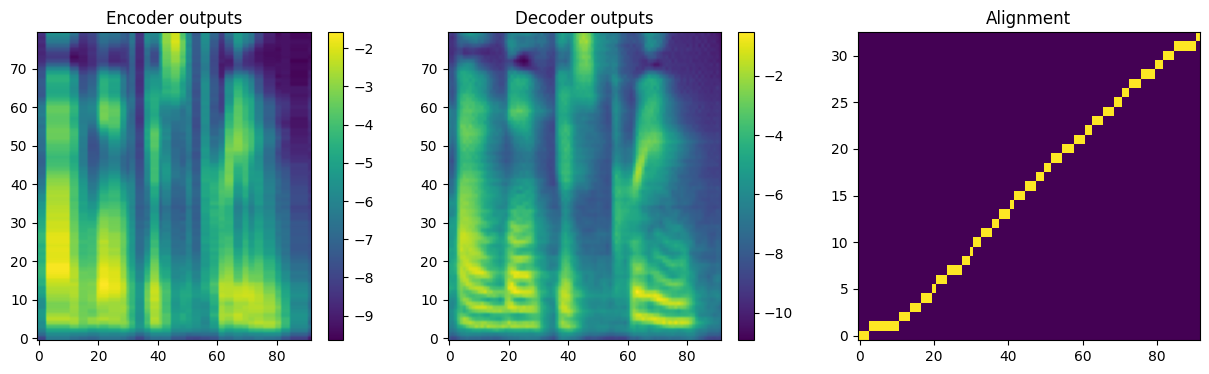

In [32]:
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=10, temperature=1.5,
                                       stoc=False, spk=torch.LongTensor([SPEAKER_ID]).cuda() if N_SPKS > 1 else None,
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title('Encoder outputs')
plt.imshow(y_enc.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title('Decoder outputs')
plt.imshow(y_dec.cpu().squeeze(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title('Alignment')
plt.imshow(attn.cpu().squeeze(), aspect='auto', origin='lower');

Restore raw waveform:

In [33]:
with torch.no_grad():
    audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))